# Impacto de las condiciones climáticas en la duración de los viajes de taxi en Chicago
**Autor:** Marcos Cruz Rojas  
**Fecha:** Diciembre 2017

----

En este Notebook se realiza un análisis del sistema de taxis en Chicago utilizando datos extraídos mediante consultas SQL y analizados en Python. El objetivo es identificar patrones de uso del servicio de transporte durante noviembre de 2017 y evaluar si factores externos, como las condiciones climáticas, influyen en la duración de los viajes.

### *Análisis exploratorio de datos EDA*

In [134]:
#Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [135]:
#cargar y leer datasets
df_companies = pd.read_csv('data/moved_project_sql_result_01.csv')
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [136]:
df_companies.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [137]:
df_locations = pd.read_csv('data/moved_project_sql_result_04.csv')
df_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [138]:
df_locations.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [139]:
df_weather = pd.read_csv('data/moved_project_sql_result_07.csv')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [140]:
df_weather.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


__*No se identificaron valores nulos en este conjunto de datos*__

In [141]:
#convertir al tipo de dato correcto
df_weather['start_ts'] = pd.to_datetime(df_weather['start_ts'])

In [142]:
#buscar las zonas con más promedio de viajes
top_10 = df_locations.sort_values(by= 'average_trips', ascending=False).head(10)

In [143]:
top_10

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


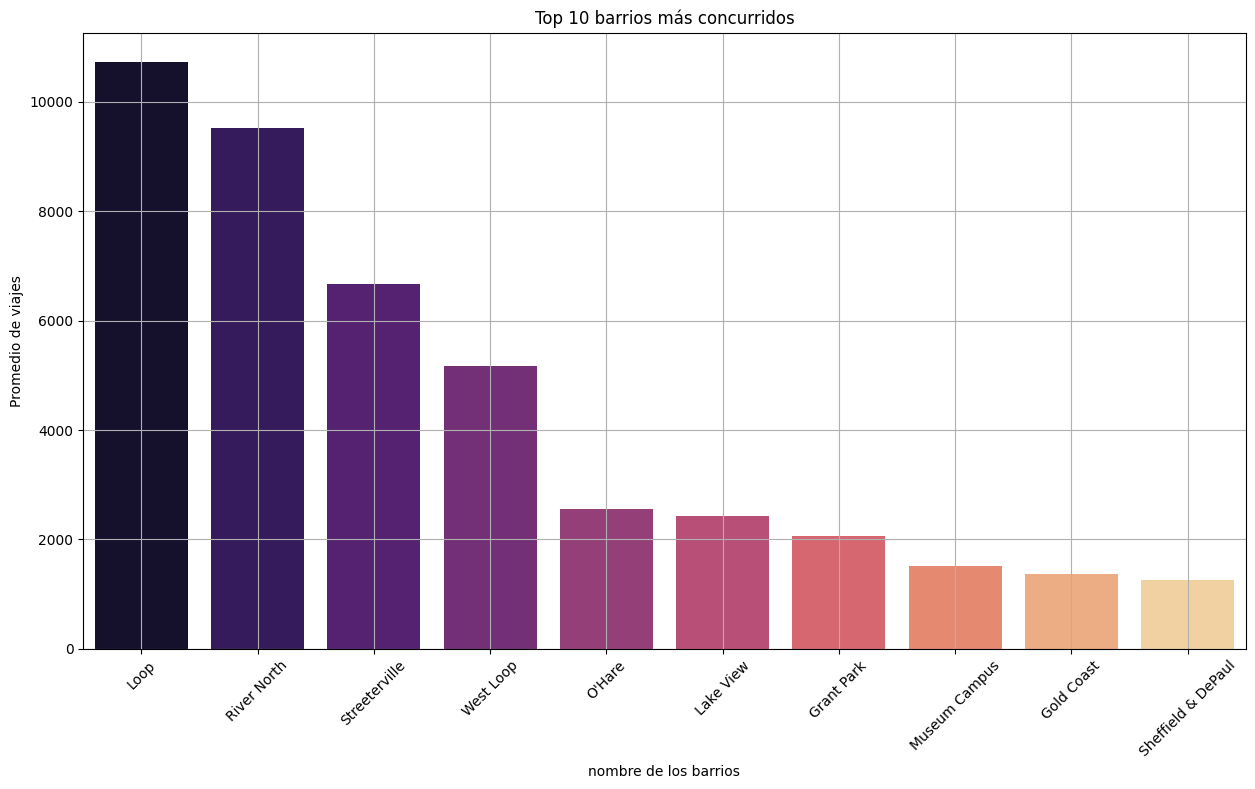

In [144]:
plt.figure(figsize=(15, 8))
sns.barplot(
    data=top_10,
    x="dropoff_location_name",
    y="average_trips",
    hue="dropoff_location_name",
    legend=False,
    palette="magma"
)
plt.title('Top 10 barrios más concurridos')
plt.xlabel('nombre de los barrios')
plt.ylabel('Promedio de viajes')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

El gráfico muestra una alta concentración de finalización de viajes en zonas centrales de Chicago.  
Loop destaca como el área con mayor promedio de viajes, superando ampliamente al resto de las zonas analizadas.  
A partir de West Loop se observa una disminución progresiva en la actividad, lo que sugiere una centralización del servicio en áreas clave de la ciudad.

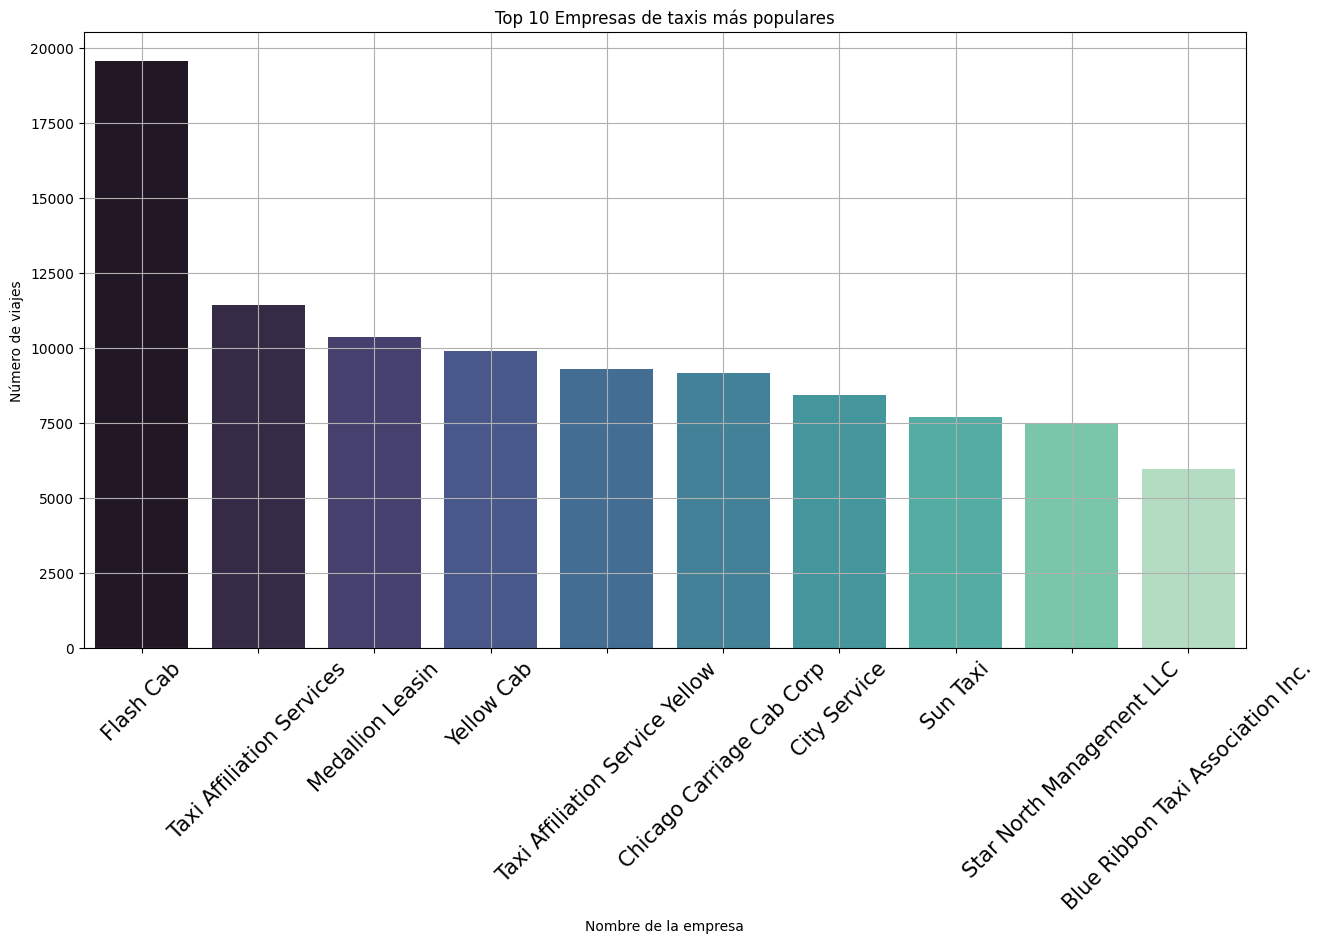

In [145]:
top_10_companies = df_companies.sort_values(by='trips_amount', ascending=False).head(10)

plt.figure(figsize=(15, 8))
sns.barplot(data=top_10_companies, x='company_name', y='trips_amount', hue= 'company_name', legend=False, palette='mako')
plt.title('Top 10 Empresas de taxis más populares')
plt.xlabel('Nombre de la empresa')
plt.ylabel('Número de viajes')
plt.grid(True)
plt.xticks(rotation=45, fontsize=15)
plt.show()

"El gráfico de barras muestra la distribución del número de viajes por empresa de taxi durante el período analizado. Los datos revelan que Flash Cab lidera significativamente el mercado con aproximadamente 12,500 viajes, representando la mayor participación entre todas las empresas evaluadas.

Esta posición dominante de Flash Cab puede atribuirse a diversos factores estratégicos, incluyendo una mayor cobertura geográfica en la ciudad, una flota más extensa, estrategias de precios competitivos, o una combinación de estos elementos que resulta en una mayor preferencia por parte de los usuarios.

Es notable la diferencia considerable entre Flash Cab y el resto de competidores, donde la segunda empresa (Taxi Affiliation Services) registra aproximadamente 11,500 viajes, evidenciando una clara concentración del mercado en las primeras posiciones."

----

## *Prueba de Hipótesis*

## Prueba de hipótesis: impacto del clima en la duración de los viajes

Se evalúa si las condiciones climáticas influyen en la duración promedio de los viajes realizados los sábados desde el área de Loop hacia el Aeropuerto Internacional O'Hare.

----

**Hipótesis nula (H₀):**  
La duración promedio de los viajes es igual en sábados con clima lluvioso y sábados sin lluvia.

**Hipótesis alternativa (H₁):**  
La duración promedio de los viajes es diferente en sábados con clima lluvioso.

In [146]:
#filtrado para obtener solo el día sabado
df_weather['day_of_week'] = df_weather['start_ts'].dt.day_name()
day_filtered = df_weather[df_weather['day_of_week'] == 'Saturday']

In [147]:
#filtrar por condición del clima
bad_weather = df_weather[df_weather['weather_conditions'] == 'Bad']['duration_seconds']
good_weather = df_weather[df_weather['weather_conditions'] == 'Good']['duration_seconds']

Se aplicó la prueba de Levene para evaluar la igualdad de varianzas entre ambos grupos, con el fin de determinar el parámetro adecuado para la prueba t de Student.

In [148]:
levene_stats, levene_p = st.levene(bad_weather, good_weather)
alpha = 0.05
print(f'p_value:', levene_p)
if levene_p > alpha:
    print('las varianzas son iguales')
else:
    print('las varianzas no son iguales')

p_value: 0.5332038671974493
las varianzas son iguales


In [149]:
t_test, p_value = st.ttest_ind(bad_weather, good_weather, equal_var=True)
alpha = 0.05
print('p_value:', p_value)
if p_value < alpha:
    print('Se rechaza la Hipótesis nula (H₀) , exiten diferencias estadísticamente significativas')
else:
    print('No podemos rechazar H₀, no existen diferencias significativas')

p_value: 6.517970327099473e-12
Se rechaza la Hipótesis nula (H₀) , exiten diferencias estadísticamente significativas


Dado que el valor p obtenido es menor al nivel de significancia (α = 0.05), se rechaza la hipótesis nula.  
Esto indica que existe una diferencia estadísticamente significativa en la duración promedio de los viajes entre sábados con clima lluvioso y no lluvioso.

In [150]:
print(f"Duración promedio - Bad_weather: {bad_weather.mean():.2f} segundos")
print(f"Duración promedio - Good_weather: {good_weather.mean():.2f} segundos")
print(f"Diferencia: {bad_weather.mean() - good_weather.mean():.2f} segundos")

Duración promedio - Bad_weather: 2427.21 segundos
Duración promedio - Good_weather: 1999.68 segundos
Diferencia: 427.53 segundos


La diferencia observada equivale aproximadamente a 7.1 minutos adicionales por viaje en condiciones climáticas adversas.
En términos prácticos, este incremento en la duración puede ser relevante tanto para pasajeros como para conductores, ya que implica mayores tiempos de traslado en días con lluvia, posiblemente asociados a congestión vehicular.

Gráfica de distribución

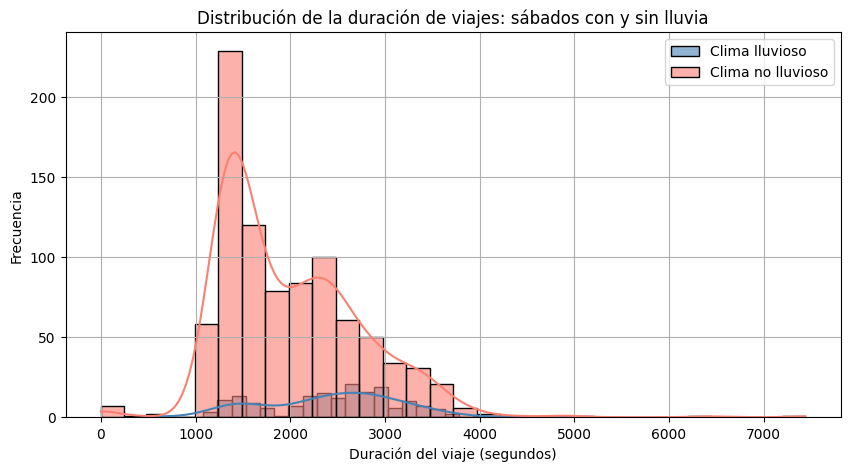

In [151]:
plt.figure(figsize=(10, 5))
sns.histplot(bad_weather, color="steelblue", label="Clima lluvioso", bins=30, kde=True, alpha=0.6)
sns.histplot(good_weather, color="salmon", label="Clima no lluvioso", bins=30, kde=True, alpha=0.6)

plt.xlabel("Duración del viaje (segundos)")
plt.ylabel("Frecuencia")
plt.title("Distribución de la duración de viajes: sábados con y sin lluvia")
plt.legend()
plt.grid(True)
plt.show()

El análisis exploratorio del sistema de taxis en Chicago permitió identificar patrones claros de uso del servicio, tanto a nivel de zonas con mayor demanda como de empresas con mayor número de viajes. Los resultados muestran una concentración significativa de viajes en áreas centrales de la ciudad, lo que evidencia una alta dependencia del servicio en zonas clave.